In [1]:
import math
import torch
import matplotlib.pyplot as plt
import numpy as np

import torchvision

from torch.utils.data import TensorDataset, DataLoader, random_split

from utils.models import *
from utils.model_tools import *
import os; os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

In [2]:
device = "cuda:1" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

!pwd

Using cuda:1 device
/home/mag/predictive-coding-thesis/src


In [3]:
latent_model_file = 'model_files/autoencoder-continuous-detach_90000_samples-200ep.pt'
latent_model = AutoEncoder()
latent_model.to(device)
latent_model.load_state_dict(torch.load(latent_model_file))#, map_location=torch.device(device)))
latent_model.eval()
for param in latent_model.parameters():
    param.requires_grad = False
    

### Testing the spatial maps

In [4]:
from torch.utils.data._utils.collate import default_collate

def normalize_coords(batch):
    """
    Custom collate function that normalizes the target values in a batch.
    Assumes each element in batch is a tuple (features, target) and target is a tensor of shape (2,)
    with target[0] as x and target[1] as y.
    """

    # Separate features and targets
    features, targets = zip(*batch)

    # Convert lists to PyTorch tensors using default collate
    features = default_collate(features)
    targets = default_collate(targets)

    # Normalize targets
    x_min, x_max = -487.5, -424.5
    y_min, y_max = -692.5, -654.5

    targets[..., 0] = (targets[..., 0] - x_min) / (x_max - x_min)  # Normalize x
    targets[..., 1] = (targets[..., 1] - y_min) / (y_max - y_min)  # Normalize y

    return features, targets[:, :-1]

def convert_yaw(batch):
    features, targets = zip(*batch)

    features = default_collate(features)
    targets = default_collate(targets)

    yaw_rad = torch.deg2rad(targets[..., 2])
    yaw_sin = torch.sin(yaw_rad)
    yaw_cos = torch.cos(yaw_rad)

    return features, torch.stack((yaw_sin, yaw_cos), -1)

In [5]:
# Load in the coordinate data
data_dir = 'data/detach-valid'

transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()
])

dataset = CoordinateDataset(source_directory=data_dir, transform=transform)#, num_samples=100000)

train_ratio = math.floor(len(dataset) * 1)
test_data, train_data = random_split(dataset, [train_ratio, len(dataset) - train_ratio])
print(f'{train_ratio} training samples')
batch_size = 16

# if you're checking yaw and not coords need to switch to normalize_yaw

#train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=convert_yaw)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=convert_yaw)

['coords_continuous_detached_2024-04-15-23-14-39.npy', 'coords_continuous_detached_2024-04-15-23-17-49.npy', 'coords_continuous_detached_2024-04-15-23-19-24.npy', 'coords_continuous_detached_2024-04-15-23-26-10.npy', 'coords_continuous_detached_2024-04-15-23-28-30.npy', 'coords_continuous_detached_2024-04-15-23-46-10.npy', 'coords_continuous_detached_2024-04-16-00-03-13.npy']
36825 training samples


In [6]:
def denormalize_targets(normalized_target):
    """
    Denormalizes the target values from the range [0, 1] back to their original scale.
    Assumes normalized_target is a tensor of shape (..., 2) where normalized_target[..., 0] is x and normalized_target[..., 1] is y.
    """
    # Define the min and max values for x and y
    x_min, x_max = -487.5, -424.5
    y_min, y_max = -692.5, -654.5

    # Denormalize x
    #print(normalized_target.shape)
    x_denormalized = normalized_target[..., 0] * (x_max - x_min) + x_min
    
    # Denormalize y
    y_denormalized = normalized_target[..., 1] * (y_max - y_min) + y_min

    # Combine and return
    return torch.stack([x_denormalized, y_denormalized], dim=-1)

def decode_yaw(normalized_target):
    torch.rad2deg(torch.atan2(normalized_target[..., 0], normalized_target[..., 1]))
    return torch.stack([normalized_target[..., 0] * (yaw_max - yaw_min) + yaw_min], dim=-1)

In [26]:
# Set up the model, which takes as input my trained predictive coder encoder and attn
device = 'cuda:1' if torch.cuda.is_available() else "cpu"

#model = LocationPredictor(latent_model, input_dim=128, hidden_dim=200)
#model = PostPredictionHDPredictor(latent_model, input_dim=144, hidden_dim=200)
model = HeadDirectionPredictor(latent_model, input_dim=128, hidden_dim=200)
model.to(device)

num_epochs = 5
steps_per_epoch = len(train_loader)

learning_rate = 0.01
weight_decay = 0.0001

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=weight_decay)
print(device)

cuda:1


In [27]:
train_losses_file = 'logs/autoencoder-continuous-detach_90000_samples-200ep-hd-predictor-train.txt'
test_losses_file = 'logs/autoencoder-continuous-detach_90000_samples-200ep-hd-predictor-test.txt'
loc_predictor_file = 'model_files/autoencoder-continuous-detach_90000_samples-200ep-hd-predictor.pt'

train_losses = []
test_losses = []
try:
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}\n-------------------------------")
        train_loss = train(train_loader, model, loss_fn, optimizer, device)
        test_loss = test(test_loader, model, loss_fn, device)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        
        torch.save(model.state_dict(), loc_predictor_file)

finally:
    torch.save(model.state_dict(), loc_predictor_file)
    
    with open(train_losses_file, 'w') as fp:
        for s in train_losses:
            fp.write("%s\n" % s)
            
    with open(test_losses_file, 'w') as fp:
        for x in test_losses:
            fp.write("%s\n" % x)
    
    print("Done!")



Epoch 1
-------------------------------
loss: 0.544546  [    0/90000]
loss: 0.465037  [16000/90000]
loss: 0.272008  [32000/90000]
loss: 0.345734  [48000/90000]
loss: 0.409609  [64000/90000]
loss: 0.245760  [80000/90000]
Test Error: 
 Avg loss: 0.326280 

Epoch 2
-------------------------------
loss: 0.345112  [    0/90000]
loss: 0.319593  [16000/90000]
loss: 0.406794  [32000/90000]
loss: 0.310365  [48000/90000]
loss: 0.284905  [64000/90000]
loss: 0.235365  [80000/90000]
Test Error: 
 Avg loss: 0.303868 

Epoch 3
-------------------------------
loss: 0.207032  [    0/90000]
loss: 0.334968  [16000/90000]
loss: 0.264812  [32000/90000]
loss: 0.160564  [48000/90000]
loss: 0.284633  [64000/90000]
loss: 0.290730  [80000/90000]
Test Error: 
 Avg loss: 0.285128 

Epoch 4
-------------------------------
loss: 0.226078  [    0/90000]
loss: 0.330570  [16000/90000]
loss: 0.326525  [32000/90000]
loss: 0.377152  [48000/90000]
loss: 0.252273  [64000/90000]
loss: 0.520819  [80000/90000]
Test Error: 
 A

In [8]:
#latent_model_file = 'model_files/continous_detached_90000_samples-200ep.pt'
#latent_model = AutoEncoder()
#latent_model.to(device)
#latent_model.load_state_dict(torch.load(latent_model_file))#, map_location=torch.device(device)))
#latent_model.eval()
#for param in latent_model.parameters():
#    param.requires_grad = False

model_file = 'model_files/autoencoder-continuous-detach_90000_samples-200ep-hd-predictor.pt'

model = HeadDirectionPredictor(latent_model, input_dim=128, hidden_dim=200)
#model = LocationPredictor(latent_model, input_dim=128, hidden_dim=200)
model.load_state_dict(torch.load(model_file))
model.to(device)
model.eval()

HeadDirectionPredictor(
  (encoder): ResNet18Enc(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlockEnc(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlockEnc(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

In [10]:
## Visualize predicted head direction
from collections import defaultdict

model.eval()
for param in model.parameters():
    param.requires_grad = False

predictions_sum = defaultdict(lambda: [torch.zeros(2), 0])

with torch.no_grad():
    #for frames, actual_yaws in test_loader:
    #    frames, actual_yaws = frames.to(device), actual_yaws.to(device)
    #    predictions = model(frames)
        #print(predictions.shape)
        #print(actual_yaws.shape)
    #    for actual, pred in zip(actual_yaws, predictions):
            #denorm_actual = denormalize_yaws(actual.cpu())
    #        actual = tuple(actual.cpu().numpy())  # Convert to a tuple for dictionary key
    #        predictions_sum[actual][0] += pred.cpu()  # Sum of predictions
    #        predictions_sum[actual][1] += 1  # Count

    for frames, actual_yaws in test_loader:
        #frames, headings = frames
        #frames, headings, actual_yaws = frames.to(device), headings.to(device), actual_yaws.to(device)
        #predictions = model(frames, headings)
        frames, actual_yaws = frames.to(device), actual_yaws.to(device)
        predictions = model(frames)

        for actual, pred in zip(actual_yaws, predictions):
            #denorm_actual = denormalize_yaws(actual.cpu())
            actual = tuple(actual.cpu().numpy())  # Convert to a tuple for dictionary key
            predictions_sum[actual][0] += pred.cpu()  # Sum of predictions
            predictions_sum[actual][1] += 1  # Count
            
# Calculate the average predicted yaw for each actual yaw
average_predictions = {actual: sum_pred[0] / sum_pred[1] for actual, sum_pred in predictions_sum.items()}

# Example: Print the average predicted yaw for each actual yaw
for actual_location, average_pred in average_predictions.items():
    print(f"Actual Yaw: {actual_location}, Average Predicted Yaw: {average_pred.numpy()}")


Actual Yaw: (0.9135455, -0.40673658), Average Predicted Yaw: [ 0.48251966 -0.19841248]
Actual Yaw: (0.9781476, 0.20791166), Average Predicted Yaw: [0.67752934 0.09222124]
Actual Yaw: (0.8746197, -0.48480955), Average Predicted Yaw: [ 0.40199772 -0.2557497 ]
Actual Yaw: (0.9205048, 0.3907312), Average Predicted Yaw: [0.6490583  0.18443713]
Actual Yaw: (0.19080901, -0.98162717), Average Predicted Yaw: [ 0.05055457 -0.46215084]
Actual Yaw: (0.99619466, 0.087155804), Average Predicted Yaw: [ 0.66669255 -0.01057388]
Actual Yaw: (0.97437006, 0.22495104), Average Predicted Yaw: [0.63830477 0.10238979]
Actual Yaw: (-0.9816272, -0.19080885), Average Predicted Yaw: [-0.5727412  -0.22551015]
Actual Yaw: (-0.37460664, -0.9271838), Average Predicted Yaw: [-0.14604181 -0.38932785]
Actual Yaw: (1.0, -4.371139e-08), Average Predicted Yaw: [0.6572867  0.00907346]
Actual Yaw: (-0.2419218, -0.9702957), Average Predicted Yaw: [-0.10753874 -0.39244705]
Actual Yaw: (-0.8290376, -0.5591929), Average Predicte

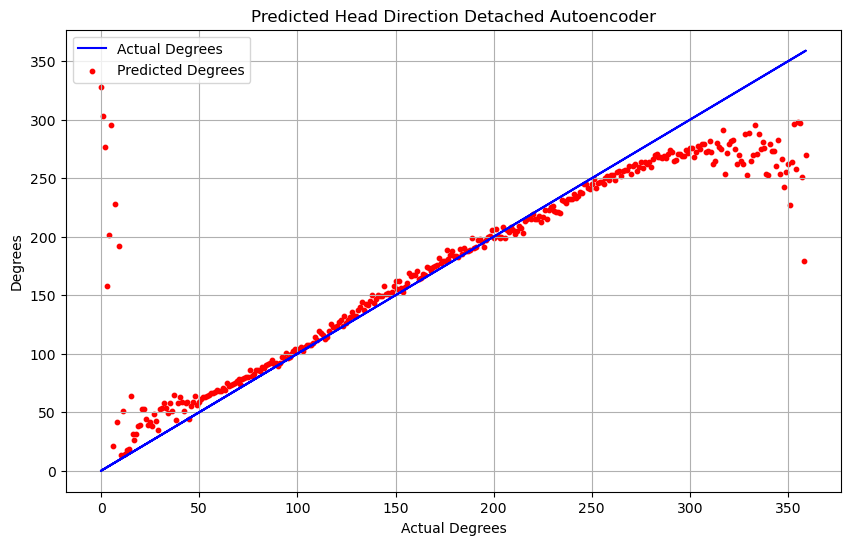

In [12]:
import numpy as np
import matplotlib.pyplot as plt

actual_sine = np.array([dir[0] for dir in average_predictions.keys()])
actual_cosine = np.array([dir[1] for dir in average_predictions.keys()])

predicted_sine = np.array([dir[0] for dir in average_predictions.values()])
predicted_cosine = np.array([dir[1] for dir in average_predictions.values()])

# Step 4: Convert predicted sine and cosine back to degrees
actual_degrees = np.degrees(np.arctan2(actual_sine, actual_cosine))
predicted_degrees = np.degrees(np.arctan2(predicted_sine, predicted_cosine))

# Handling the transition from 360 to 0 degrees
actual_degrees = actual_degrees % 360
predicted_degrees = predicted_degrees % 360

# Step 5: Plot both actual and predicted values
plt.figure(figsize=(10, 6))
plt.plot(actual_degrees, actual_degrees, label='Actual Degrees', color='blue')
plt.scatter(actual_degrees, predicted_degrees, color='red', s=10, label='Predicted Degrees')
plt.title('Predicted Head Direction Detached Autoencoder')
plt.xlabel('Actual Degrees')
plt.ylabel('Degrees')
plt.legend()
plt.grid(True)
plt.show()


In [16]:

plt.figure(figsize=(8, 6))
plt.scatter(average_predictions.keys(), average_predictions.values(), alpha=0.7, color='blue', label='Predicted vs Actual')
plt.title('Continuous Model Predicted Yaws vs Actual Yaws')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.plot([0, 285], [0, 285], 'r--', label='Perfect Prediction')  # Red dashed line for perfect prediction
plt.xlim([0, 285])
plt.ylim([0, 285])
plt.legend()
plt.grid(True)
plt.show()
plt.savefig('continuous-predicted-yaws.png')
plt.close()

NameError: name 'average_predictions' is not defined

<Figure size 800x600 with 0 Axes>

In [9]:
import torch
from collections import defaultdict

model.eval()  # Set the model to evaluation mode

# Dictionary to store sum of predictions and count for each actual location
predictions_sum = defaultdict(lambda: [torch.zeros(2), 0])

with torch.no_grad():  # Disable gradient computation
    for frames, actual_locations in test_loader:
        frames, headings = frames
        frames, headings, actual_locations = frames.to(device), headings.to(device), actual_locations.to(device)
        # Pass the features through the model to get predictions
        predictions = model(frames, headings)

        # Iterate through the batch and update the predictions_sum dictionary
        for actual, pred in zip(actual_locations, predictions):
            denorm_actual = denormalize_targets(actual.cpu())
            actual = tuple(denorm_actual.numpy())  # Convert to a tuple for dictionary key
            predictions_sum[actual][0] += pred.cpu()  # Sum of predictions
            predictions_sum[actual][1] += 1  # Count

    #for frames, actual_locations in train_loader:
    #    frames, actual_locations = frames.to(device), actual_locations.to(device)
        # Pass the features through the model to get predictions
   #     predictions = model(frames)

        # Iterate through the batch and update the predictions_sum dictionary
    #    for actual, pred in zip(actual_locations, predictions):
    #        denorm_actual = denormalize_targets(actual.cpu())
    #        actual = tuple(denorm_actual.numpy())  # Convert to a tuple for dictionary key
    #        predictions_sum[actual][0] += pred.cpu()  # Sum of predictions
    #        predictions_sum[actual][1] += 1  # Count
            
# Calculate the average predicted location for each actual location
average_predictions = {actual: denormalize_targets(sum_pred[0] / sum_pred[1]) for actual, sum_pred in predictions_sum.items()}

#for actual_location, average_pred in average_predictions.items():
#    print(f"Actual Location: {actual_location}, Average Predicted Location: {average_pred.numpy()}")


In [10]:
import pickle 

f = open("logs/continuous_locs_just_valid.pkl","wb")

# write the python object (dict) to pickle file
pickle.dump(average_predictions, f)

# close file
f.close()

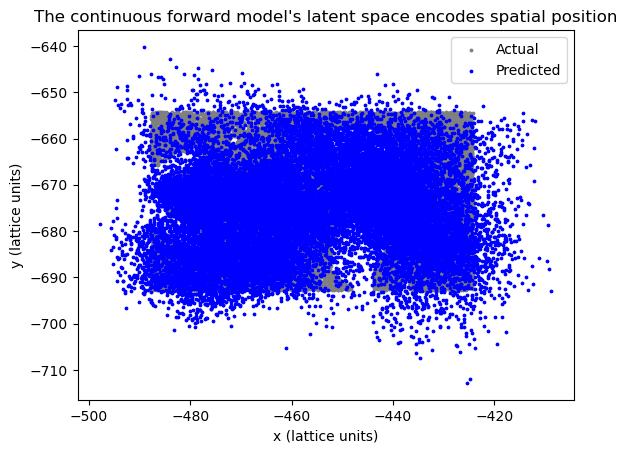

In [11]:
import matplotlib.pyplot as plt
import numpy as np

f = open("logs/continuous_locs_just_valid.pkl", "rb")
average_predictions = pickle.load(f)

# Assuming we have two sets of data points, one for actual (ground truth) and one for predicted
# For demonstration, random points around a line y=x will be generated for actual
# and points with some added noise for predicted

np.random.seed(0) # for reproducibility

actual_x = np.array([pos[0] for pos in average_predictions.keys()])
actual_y = np.array([pos[1] for pos in average_predictions.keys()])

predicted_x = np.array([pos[0] for pos in average_predictions.values()])
predicted_y = np.array([pos[1] for pos in average_predictions.values()])

# Calculate errors (distance) between actual and predicted points
errors_x = predicted_x - actual_x
errors_y = predicted_y - actual_y
errors = np.sqrt(errors_x**2 + errors_y**2)

# Create the figure and the axis
fig, ax = plt.subplots()

# Plot actual points
ax.scatter(actual_x, actual_y, s=3, color='gray', label='Actual')

# Plot predicted points
ax.scatter(predicted_x, predicted_y, s=3, color='blue', label='Predicted')

# Plot error lines
#for i in range(len(actual_x)):
#    ax.plot([actual_x[i], predicted_x[i]], [actual_y[i], predicted_y[i]], color='gray', linewidth=2, alpha=0.05)

# Set labels and title
ax.set_xlabel('x (lattice units)')
ax.set_ylabel('y (lattice units)')
ax.set_title('The continuous forward model\'s latent space encodes spatial position')

# Add legend
ax.legend()

# Show the plot
plt.show()


In [40]:
# I actually think it's spreading them out maybe because with the outer points, there's not a lot of confusion

## Analyze the distance errors between baseline models  

In [12]:
# Make the predictive coding model (face north)
average_predictions_north = np.load('logs/continuous_facenorth_post_pred_locs_just_valid.pkl', allow_pickle=True)
base_np = np.stack(list(average_predictions_north.keys()))
predictive_values = np.stack([pos for pos in average_predictions_north.values()], axis=0)
data_predictive_coding = np.linalg.norm(predictive_values - base_np, axis=1)

# Make the predictive coding model (facing forward)
average_predictions = np.load('logs/continuous_locs_just_valid.pkl', allow_pickle=True)
base_np = np.stack(list(average_predictions.keys()))
predictive_values = np.stack([pos for pos in average_predictions.values()], axis=0)
data_predictive_coding_forward = np.linalg.norm(predictive_values - base_np, axis=1)

# Make the predictive coding model (detached head dir)
average_predictions_detached = np.load('logs/continuous_detach_locs_just_valid.pkl', allow_pickle=True)
base_np = np.stack(list(average_predictions_detached.keys()))
predictive_values = np.stack([pos for pos in average_predictions_detached.values()], axis=0)
data_predictions_detached = np.linalg.norm(predictive_values - base_np, axis=1)

# Make the continuous autoencoder model
autoencoder_locs = np.load('logs/continuous_autoencoder_locs_just_valid.pkl', allow_pickle=True)
base_np = np.stack(list(autoencoder_locs.keys()))
autoencode_values = np.stack([pos for pos in autoencoder_locs.values()], axis=0)
data_auto_encoding = np.linalg.norm(autoencode_values - base_np, axis=1)

# detached head autoencoder
autoencoder_locs = np.load('logs/continuous_detach_autoencoder_locs_just_valid.pkl', allow_pickle=True)
base_np = np.stack(list(autoencoder_locs.keys()))
autoencode_values = np.stack([pos for pos in autoencoder_locs.values()], axis=0)
data_auto_encoding_detach = np.linalg.norm(autoencode_values - base_np, axis=1)

# Make the shuffle model
shuffled = base_np.copy()
np.random.shuffle(shuffled)
print(shuffled.shape)
data_random_pairs = np.linalg.norm(shuffled - base_np, axis=1)

# 

# Make the added noise model
std = 1
added_noise = []

for pos in average_predictions.keys():
    noise = np.random.normal(0, std)
    added_noise.append([pos[0] + noise, pos[1] + noise])

noisy_np = np.stack(added_noise, axis=0)
base_np = np.stack(list(average_predictions.keys()))
data_noise_model = np.linalg.norm(noisy_np - base_np, axis=1)

(36818, 2)


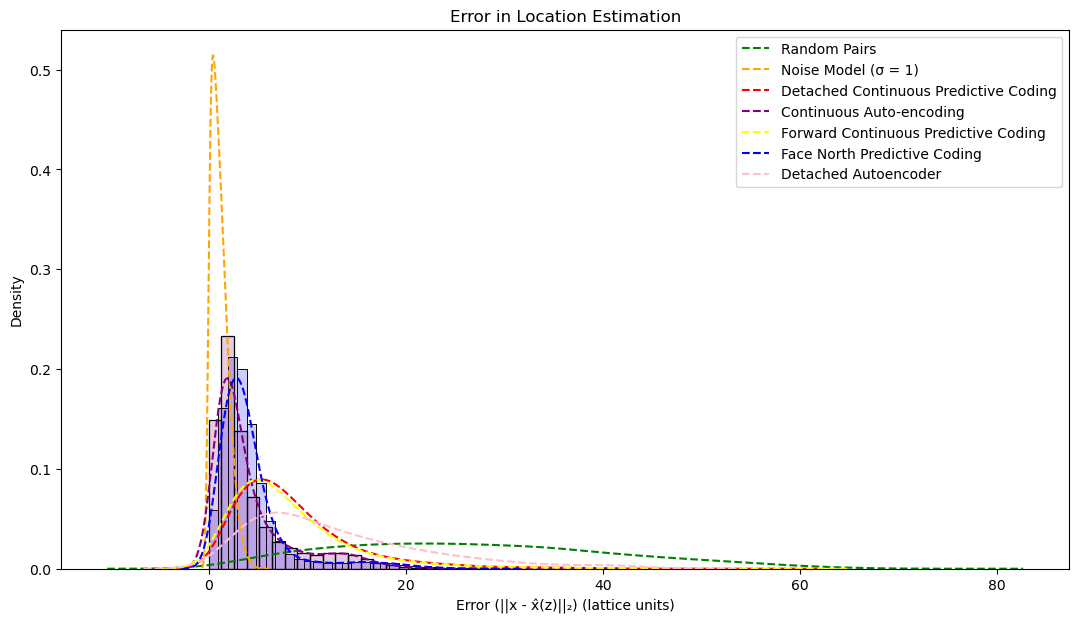

In [13]:
import seaborn as sns

plt.figure(figsize=(13, 7))

# Plotting KDE for all distributions
sns.kdeplot(data_random_pairs, bw_adjust=2, label="Random Pairs", color="green", linestyle="--")
sns.kdeplot(data_noise_model, bw_adjust=2, label="Noise Model (σ = 1)", color="orange", linestyle="--")
sns.kdeplot(data_predictions_detached, bw_adjust=2, label="Detached Continuous Predictive Coding", color="red", linestyle="--")
sns.kdeplot(data_auto_encoding, bw_adjust=2, label="Continuous Auto-encoding", color="purple", linestyle="--")
sns.kdeplot(data_predictive_coding_forward, bw_adjust=2, label="Forward Continuous Predictive Coding", color="yellow", linestyle="--")
sns.kdeplot(data_predictive_coding, bw_adjust=2, label="Face North Predictive Coding", color="blue", linestyle="--")
sns.kdeplot(data_auto_encoding_detach, bw_adjust=2, label="Detached Autoencoder", color="pink", linestyle="--")

# Plotting histograms only for predictive coding and auto-encoding with normalization
sns.histplot(data_predictive_coding, kde=False, color="blue", alpha=0.2, bins=30, stat="density")
sns.histplot(data_auto_encoding, kde=False, color="purple", alpha=0.2, bins=30, stat="density")

# Additional plot formatting to match the user's request
plt.title('Error in Location Estimation')
plt.xlabel('Error (||x - x̂(z)||₂) (lattice units)')
plt.ylabel('Density')
plt.legend()
plt.show()


# rerun the autoencoder

# starting with the face north task? curricular training -- critical period? smaller environment?
# maybe you do want to examine this still on a discrete sampling scheme
